In [134]:
import pandas as pd 
import statsmodels.tsa as tsa
import statsmodels.api as sm
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')

In [135]:
data=pd.read_csv('durham_training.csv')

#data=data.loc[:365]

#defining date_received as a datetime field in pandas
data['date_received'] = pd.to_datetime(data['date_received'])

#Defining date_received as index
data.index=data['date_received']
data.columns

Index(['date_received', 'citizen_init_count', 'officer_init_count',
       'year_received', 'month_received', 'week_received', 'day_received',
       'dow_received', 'apparentTemperatureMax', 'apparentTemperatureMin',
       'cloudCover', 'dewPoint', 'humidity', 'icon', 'moonPhase',
       'precipAccumulation', 'precipIntensity', 'precipIntensityMax',
       'precipProbability', 'precipType', 'pressure', 'temperatureMax',
       'temperatureMin', 'visibility', 'windBearing', 'windSpeed',
       'daylightSeconds', 'apparentTemperatureMax_ln',
       'apparentTemperatureMax_quartile', 'apparentTemperatureMax_binary',
       'apparentTemperatureMin_ln', 'apparentTemperatureMin_quartile',
       'apparentTemperatureMin_binary', 'cloudCover_ln', 'cloudCover_quartile',
       'cloudCover_binary', 'dewPoint_ln', 'dewPoint_quartile',
       'dewPoint_binary', 'humidity_ln', 'humidity_quartile',
       'humidity_binary', 'moonPhase_ln', 'moonPhase_quartile',
       'moonPhase_binary', 'precipIn

In [136]:
#Creating constant column for model intercept
data['constant']=1

#Dummy Variable for DOW
dow_dummies=pd.get_dummies(data['dow_received'], prefix='dow')
dow_columns=list(dow_dummies.columns.values)
data=data.join(dow_dummies, how='left')

#Dummy Variable for month
month_dummies=pd.get_dummies(data['month_received'], prefix='month')
month_columns=list(month_dummies.columns.values)

data=data.join(month_dummies, how='left')

#Dummy Variable for TMAX_CAT
tmax_dummies=pd.get_dummies(data['apparentTemperatureMax_quartile'], prefix='tmax')
tmax_columns=list(tmax_dummies.columns.values)
data=data.join(tmax_dummies, how='left')

#Interaction Column
data['pressure_wind']=data['pressure_ln']*data['windSpeed']

In [137]:
glm_vars=['constant', 'christmas', 'thanksgiving', 'humidity', 'pressure_ln', 'temperatureMax_ln', 'windSpeed','pressure_wind']
glm_vars=glm_vars+dow_columns[:-1]+month_columns[:-1]+tmax_columns[:-1]

In [138]:
glm_vars

['constant',
 'christmas',
 'thanksgiving',
 'humidity',
 'pressure_ln',
 'temperatureMax_ln',
 'windSpeed',
 'pressure_wind',
 'dow_0',
 'dow_1',
 'dow_2',
 'dow_3',
 'dow_4',
 'dow_5',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'tmax_1',
 'tmax_2',
 'tmax_3']

In [139]:
#Fitting GLM model
mod = sm.OLS(data['citizen_init_count'], data[glm_vars])
reg =mod.fit()

In [140]:
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:     citizen_init_count   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     113.0
Date:                Thu, 24 Sep 2015   Prob (F-statistic):               0.00
Time:                        14:15:29   Log-Likelihood:                -14316.
No. Observations:                2891   AIC:                         2.869e+04
Df Residuals:                    2863   BIC:                         2.886e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
constant          -5422.8674   1770.99

In [141]:
#Creating dataframe for timeseries portion fitting
for_ts=pd.DataFrame()
for_ts['glm_resid']=reg.resid
for_ts['count']=data['citizen_init_count']
for_ts['glm_value']=reg.fittedvalues
for_ts['week']=data['week_received']
for_ts['month']=data['month_received']
for_ts['year']=data['year_received']

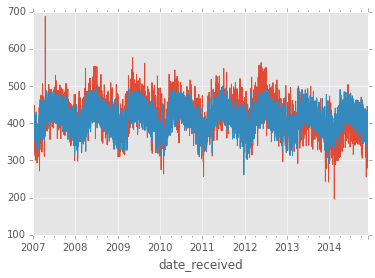

In [142]:
#Predicted glm vs. actuals
for_ts['count'].plot()
for_ts['glm_value'].plot()

In [143]:
#Fitting (1,1) ARMA Model on ARMA residuals
ts_model = tsa.arima_model.ARMA(for_ts['glm_resid'], (2,1))
ts_model_fit=ts_model.fit()

In [144]:
ts_model_fit.params

const             -5.270577
ar.L1.glm_resid    1.104241
ar.L2.glm_resid   -0.106164
ma.L1.glm_resid   -0.961924
dtype: float64

In [114]:
#Adding ARMA model outputs to df
for_ts['ts_value']=ts_model_fit.fittedvalues
#for_ts['ts_resid']=ts_model_fit.resid

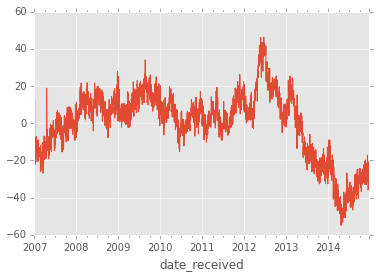

In [115]:
#Plot of AMRA Adjustments
for_ts['ts_value'].plot()

In [116]:
#final prediction and final error
for_ts['final_prediction']=for_ts['glm_value']+for_ts['ts_value']
for_ts['final_resid']=for_ts['count']-for_ts['final_prediction']

In [117]:
#Daily MAPEs
for_ts['glm_mape']=abs((for_ts['count']-for_ts['glm_value'])/for_ts['count'])
for_ts['final_mape']=abs((for_ts['count']-for_ts['final_prediction'])/for_ts['count'])

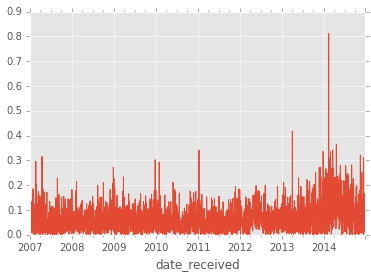

In [118]:
for_ts['glm_mape'].plot()


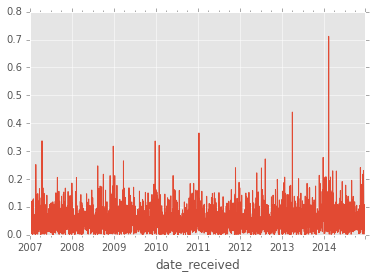

In [119]:
for_ts['final_mape'].plot()

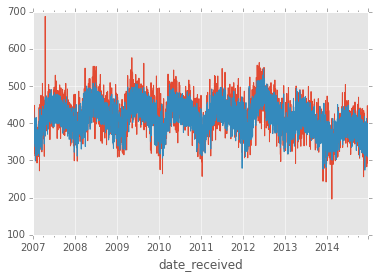

In [120]:
#Actuals vs. predicted
for_ts['count'].plot()
for_ts['final_prediction'].plot()


In [121]:
#MAPE after GLM
sum(for_ts['glm_mape'])/len(for_ts['glm_mape'])*100

6.5549882510450299

In [122]:
#MAPE after GLM + ARMA
sum(for_ts['final_mape'])/len(for_ts['glm_mape'])*100

5.4974585273349064

In [123]:
sorted_df=for_ts.sort('final_mape', ascending=False)

In [124]:
#Days model was worst on
sorted_df[0:20]

,glm_resid,count,glm_value,week,month,year,ts_value,final_prediction,final_resid,glm_mape,final_mape
date_received,,,,,,,,,,,
2014-02-13,-159.159379,196,355.159379,7,2,2014,-19.745543,335.413836,-139.413836,0.812038,0.711295
2013-04-03,-122.160282,292,414.160282,14,4,2013,6.270295,420.430576,-128.430576,0.418357,0.439831
2011-01-11,-87.796039,257,344.796039,2,1,2011,5.968874,350.764914,-93.764914,0.341619,0.364844
2007-04-16,217.145873,687,469.854127,16,4,2007,-14.208968,455.645159,231.354841,0.316078,0.336761
2009-12-26,-94.403740,312,406.403740,52,12,2009,10.469667,416.873407,-104.873407,0.302576,0.336133
2010-01-30,-81.171689,277,358.171689,4,1,2010,7.619976,365.791665,-88.791665,0.293039,0.320548
2008-12-26,-85.671338,335,420.671338,52,12,2008,20.702522,441.373860,-106.373860,0.255735,0.317534
2008-12-27,-90.745439,333,423.745439,52,12,2008,5.159631,428.905070,-95.905070,0.272509,0.288003
2013-12-27,-106.573698,317,423.573698,52,12,2013,-18.670331,404.903367,-87.903367,0.336195,0.277298


In [125]:
#Days model was best on
sorted_df[-20:]

,glm_resid,count,glm_value,week,month,year,ts_value,final_prediction,final_resid,glm_mape,final_mape
date_received,,,,,,,,,,,
2013-06-22,-20.466643,436,456.466643,25,6,2013,-20.825994,435.640649,0.359351,0.046942,8.241993e-04
2009-09-05,16.859673,461,444.140327,36,9,2009,16.502292,460.642619,0.357381,0.036572,7.752292e-04
2010-09-16,-4.529434,443,447.529434,37,9,2010,-4.221369,443.308065,-0.308065,0.010224,6.954070e-04
2013-07-20,-21.400463,435,456.400463,29,7,2013,-21.675848,434.724615,0.275385,0.049196,6.330683e-04
2011-07-24,-4.389460,405,409.389460,29,7,2011,-4.616186,404.773274,0.226726,0.010838,5.598180e-04
2007-07-24,3.679263,446,442.320737,30,7,2007,3.913610,446.234347,-0.234347,0.008249,5.254417e-04
2007-04-06,-13.182485,423,436.182485,14,4,2007,-12.976020,423.206465,-0.206465,0.031164,4.880976e-04
2010-08-29,3.325605,392,388.674395,34,8,2010,3.145960,391.820355,0.179645,0.008484,4.582787e-04
2011-11-19,22.306768,445,422.693232,46,11,2011,22.482047,445.175280,-0.175280,0.050128,3.938874e-04


In [83]:
#Aggregating predictions up to weekly level
weekly_df=for_ts.groupby(by=[for_ts.index.year, for_ts.index.week]).sum()
weekly_df['glm_mape']=abs((weekly_df['count']-weekly_df['glm_value'])/weekly_df['count'])
weekly_df['final_mape']=abs((weekly_df['count']-weekly_df['final_prediction'])/weekly_df['count'])

In [84]:
#GLM MAPE
sum(weekly_df['glm_mape'])/len(weekly_df['glm_mape'])*100


4.1615349862387285

In [85]:
#Full MAPE
sum(weekly_df['final_mape'])/len(weekly_df['glm_mape'])*100

2.1001626580779176

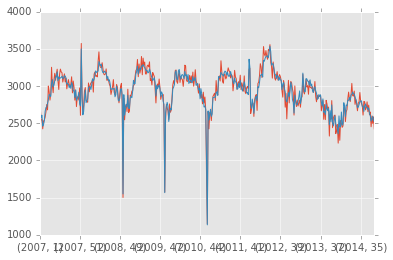

In [86]:
weekly_df['count'].plot()
weekly_df['final_prediction'].plot()

In [87]:
#Aggregating predictions up to monthly level
month_df=for_ts.groupby(by=[for_ts.index.year, for_ts.index.month]).sum()
month_df['glm_mape']=abs((month_df['count']-month_df['glm_value'])/month_df['count'])
month_df['final_mape']=abs((month_df['count']-month_df['final_prediction'])/month_df['count'])

In [88]:
#GLM MAPE
sum(month_df['glm_mape'])/len(month_df['glm_mape'])*100

3.6183145539281183

In [89]:
#Full Mape
sum(month_df['final_mape'])/len(month_df['glm_mape'])*100

0.97794316544668447

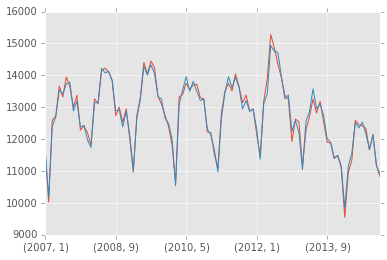

In [90]:
month_df['count'].plot()
month_df['final_prediction'].plot()

In [91]:
year_df=for_ts.groupby(by=[for_ts.index.year]).sum()
year_df['glm_mape']=abs((year_df['count']-year_df['glm_value'])/year_df['count'])
year_df['final_mape']=abs((year_df['count']-year_df['final_prediction'])/year_df['count'])

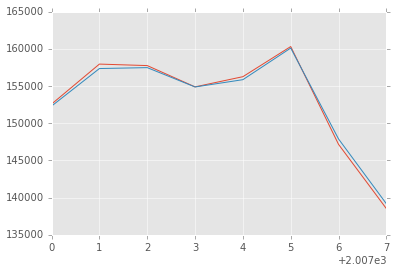

In [92]:
year_df['count'].plot()
year_df['final_prediction'].plot()

In [93]:
year_df

,glm_resid,count,glm_value,week,month,year,ts_value,final_prediction,final_resid,glm_mape,final_mape
2007,-2105.458074,152569,154674.458074,9647,2382,732555,-2373.692138,152300.765937,268.234063,0.013800,0.001758
2008,4108.725808,157945,153836.274192,9648,2384,734928,3509.424396,157345.698588,599.301412,0.026014,0.003794
2009,4888.462376,157743,152854.537624,9855,2382,733285,4615.411947,157469.949571,273.050429,0.030990,0.001731
2010,1369.454059,154882,153512.545941,9701,2382,733650,1357.155555,154869.701495,12.298505,0.008842,0.000079
2011,2178.344806,156253,154074.655194,9698,2382,734015,1776.080489,155850.735683,402.264317,0.013941,0.002574
2012,6644.780073,160302,153657.219927,9699,2384,736392,6441.130214,160098.350141,203.649859,0.041452,0.001270
2013,-4089.441466,147154,151243.441466,9647,2382,734745,-3362.163764,147881.277702,-727.277702,0.027790,0.004942
2014,-12994.867582,138519,151513.867582,9646,2370,733096,-12341.412541,139172.455041,-653.455041,0.093813,0.004717


In [145]:
#Let's see why we did by comparing to our hold-out validation set -- the last two months of the dataset
validation_data=pd.read_csv('durham_validation.csv')
#validation_data=validation_data.loc[0:180]
validation_data['date_received'] = pd.to_datetime(validation_data['date_received'])
validation_data.index=validation_data['date_received']
validation_data['constant']=1



#Dummy Variable for DOW
dow_dummies=pd.get_dummies(validation_data['dow_received'], prefix='dow')
dow_columns=list(dow_dummies.columns.values)
validation_data=validation_data.join(dow_dummies, how='left')

#Dummy Variable for month
month_dummies=pd.get_dummies(validation_data['month_received'], prefix='month')
month_columns=list(month_dummies.columns.values)
validation_data=validation_data.join(month_dummies, how='left')


#Dummy Variable for TMAX_CAT
tmax_dummies=pd.get_dummies(validation_data['apparentTemperatureMax_quartile'], prefix='tmax')
tmax_columns=list(tmax_dummies.columns.values)
validation_data=validation_data.join(tmax_dummies, how='left')

#Interaction Column
validation_data['pressure_wind']=validation_data['pressure_ln']*validation_data['windSpeed']

for column in glm_vars:
    if column not in validation_data.columns:
        validation_data[column]=0

In [146]:
validation_data['glm_forecast']=reg.predict(validation_data[glm_vars])
validation_data['arima_adjust']=ts_model_fit.forecast(steps=len(validation_data))[0]

In [147]:
validation_data['forecast']=validation_data['glm_forecast']+validation_data['arima_adjust']
final_weekly_forecast=validation_data.groupby(by=[validation_data.index.week]).sum()
final_monthly_forecast=validation_data.groupby(by=[validation_data.index.month]).sum()

In [148]:
validation_data['final_mape']=abs((validation_data['citizen_init_count']-validation_data['forecast'])/validation_data['citizen_init_count'])

In [149]:
#MAPE after GLM + ARMA
sum(validation_data['final_mape'])/len(validation_data['final_mape'])*100

6.9059171920681086

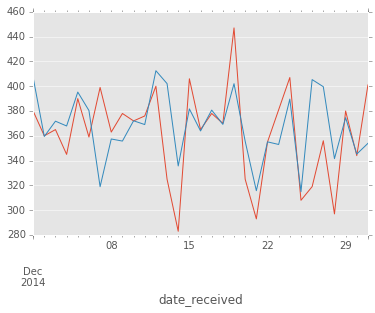

In [150]:
#Actuals vs. predicted
validation_data['citizen_init_count'].plot()
validation_data['forecast'].plot()

In [151]:
#Aggregating predictions up to weekly level
weekly_df=validation_data.groupby(by=[validation_data.index.year, validation_data.index.week]).sum()
weekly_df['final_mape']=abs((weekly_df['citizen_init_count']-weekly_df['forecast'])/weekly_df['citizen_init_count'])

In [152]:
sum(weekly_df['final_mape'])/len(weekly_df['final_mape'])*100

3.0340012636881522

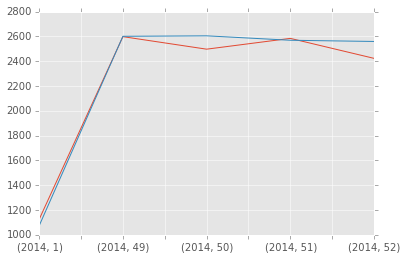

In [153]:
#Actuals vs. predicted
weekly_df['citizen_init_count'].plot()
weekly_df['forecast'].plot()

In [154]:
#Aggregating predictions up to monthly level
monthly_df=validation_data.groupby(by=[validation_data.index.year, validation_data.index.month]).sum()
monthly_df['final_mape']=abs((monthly_df['citizen_init_count']-monthly_df['forecast'])/monthly_df['citizen_init_count'])
sum(monthly_df['final_mape'])/len(monthly_df['final_mape'])*100

1.6063943907654692

/Users/pruddle/anaconda/envs/py34/lib/python3.4/site-packages/matplotlib/axes/_base.py:2562: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


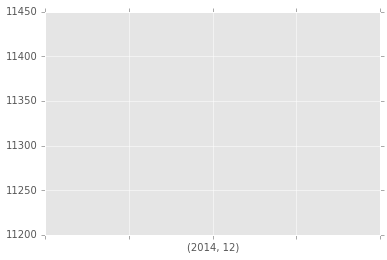

In [155]:
#Actuals vs. predicted
monthly_df['citizen_init_count'].plot()
monthly_df['forecast'].plot()

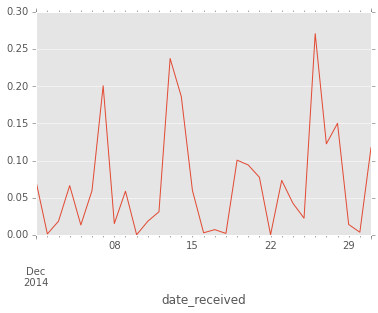

In [156]:
validation_data['final_mape'].plot()

In [57]:
yearly_df=validation_data.groupby(by=[validation_data.index.year]).sum()

In [58]:
yearly_df

,citizen_init_count,officer_init_count,year_received,month_received,week_received,day_received,dow_received,apparentTemperatureMax,apparentTemperatureMin,cloudCover,...,month_12,tmax_1,tmax_2,tmax_3,tmax_4,pressure_wind,glm_forecast,arima_adjust,forecast,final_mape
2014,138920,149413,735110,2382,9647,5738,1094,24976.18,17186.96,64.42,...,31,105,83,100,77,12332.290089,153870.17475,-6012.100201,147858.074549,32.635165


In [59]:
validation_data

,date_received,citizen_init_count,officer_init_count,year_received,month_received,week_received,day_received,dow_received,apparentTemperatureMax,apparentTemperatureMin,...,month_12,tmax_1,tmax_2,tmax_3,tmax_4,pressure_wind,glm_forecast,arima_adjust,forecast,final_mape
date_received,,,,,,,,,,,,,,,,,,,,,
2014-01-01,2014-01-01,431,397,2014,1,1,1,2,47.19,25.38,...,0,1,0,0,0,18.239589,378.041164,-22.663406,355.377757,0.175458
2014-01-02,2014-01-02,330,521,2014,1,1,2,3,45.05,35.69,...,0,1,0,0,0,17.437803,377.137943,-26.049435,351.088508,0.063905
2014-01-03,2014-01-03,473,483,2014,1,1,3,4,34.98,11.78,...,0,1,0,0,0,69.719991,402.991495,-26.348855,376.642640,0.203715
2014-01-04,2014-01-04,300,386,2014,1,1,4,5,35.27,9.38,...,0,1,0,0,0,16.376708,376.305401,-26.309200,349.996201,0.166654
2014-01-05,2014-01-05,309,354,2014,1,1,5,6,54.52,32.73,...,0,1,0,0,0,9.836840,339.331928,-26.232531,313.099397,0.013267
2014-01-06,2014-01-06,373,462,2014,1,2,6,0,59.32,3.48,...,0,0,1,0,0,66.067492,421.553533,-26.152056,395.401478,0.060058
2014-01-07,2014-01-07,352,593,2014,1,2,7,1,15.79,-4.12,...,0,1,0,0,0,48.218987,346.080425,-26.071424,320.009001,0.090884
2014-01-08,2014-01-08,364,574,2014,1,2,8,2,38.31,7.94,...,0,1,0,0,0,24.992147,368.277106,-25.991036,342.286070,0.059654
2014-01-09,2014-01-09,351,582,2014,1,2,9,3,51.69,25.02,...,0,1,0,0,0,16.174482,387.362672,-25.910935,361.451737,0.029777
